In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# %matplotlib inline

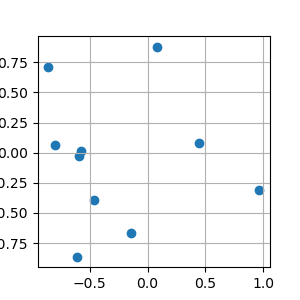

In [2]:
n = 10
X = 2*np.random.rand(n, 2)-1

plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:,1])
plt.grid(), plt.show();

## Gaussian kernel vs. Bernoulli process

In [8]:
def gauss(sigma):
    def kernel(tau):
        return np.exp(-np.sum(tau**2, axis=-1)/sigma**2)
    return kernel

def KernelMatrix(x,y,h):
    return h(x[:,None]-y[None,:])

K = KernelMatrix(X,X,gauss(2))
print(f"first 5 cols,rows:\n{K[:5,:5]}")

first 5 cols,rows:
[[1.         0.63200696 0.85497218 0.73575437 0.53938662]
 [0.63200696 1.         0.58766496 0.90798547 0.62209617]
 [0.85497218 0.58766496 1.         0.54969033 0.80885451]
 [0.73575437 0.90798547 0.54969033 1.         0.44457193]
 [0.53938662 0.62209617 0.80885451 0.44457193 1.        ]]


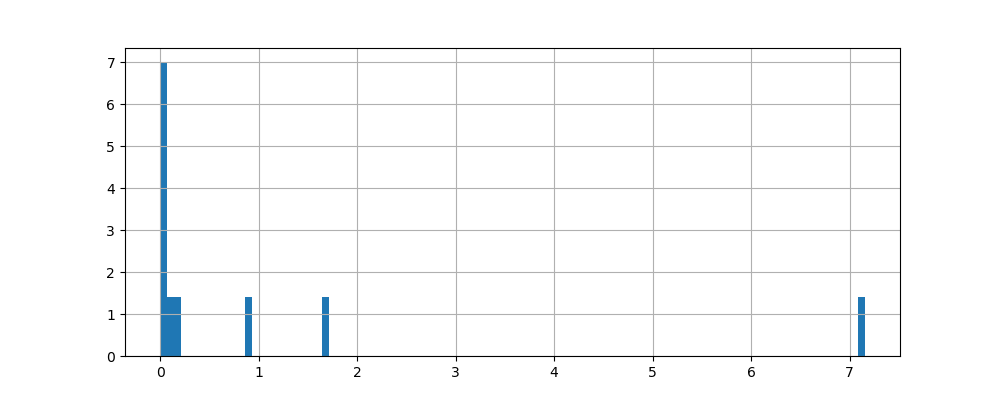

In [9]:
w, v = np.linalg.eigh(K)
    
plt.figure(figsize=(10,4))
plt.hist(w,100, density=True)
plt.grid();

(100, 100)


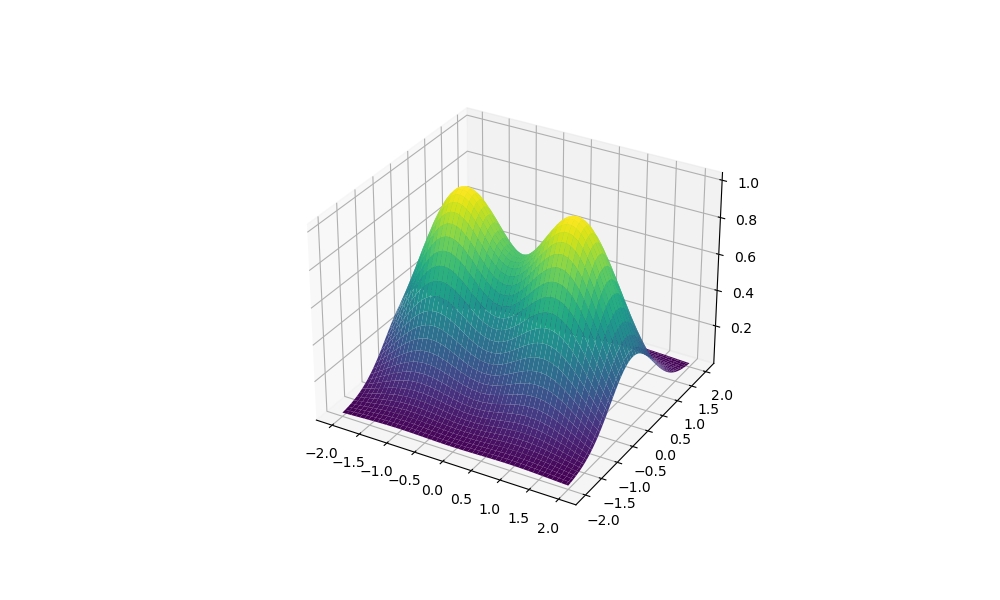

In [10]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

nb_discr = 100
x, y = np.linspace(-2, 2, nb_discr), np.linspace(-2, 2, nb_discr)
xx, yy = np.meshgrid(x, y)
xy = np.array([xx, yy]).transpose(1,2,0)

mu_1 = [-1,0]
mu_2 = [1,0]
C = 0.5
zz = np.exp( -np.sum((xy - mu_1)**2, axis=-1)/(2*C)) + np.exp( -np.sum((xy - mu_2)**2, axis=-1)/(2*C))
print(zz.shape)

surf = ax.plot_surface(xx, yy, zz, cmap="viridis")
plt.show()

## OPE kernel

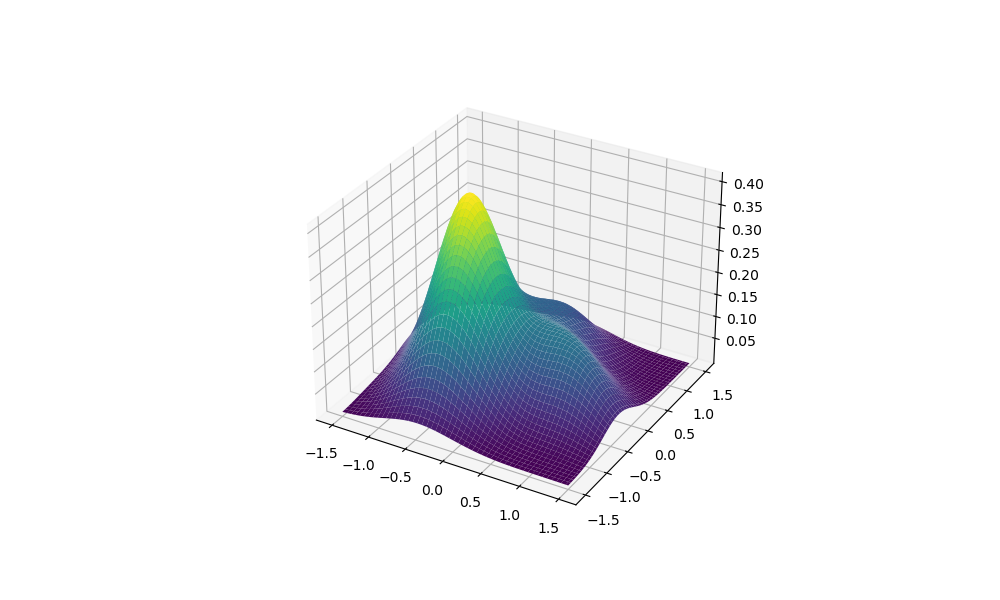

In [3]:
import scipy.stats as stats
gamma_tilde = stats.gaussian_kde(X.T)
gamma_tilde_X = gamma_tilde.pdf(X.T)

plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
nb_discr = 100
cube_limit = 1.5
x, y = np.linspace(-cube_limit, cube_limit, nb_discr), np.linspace(-cube_limit, cube_limit, nb_discr)
xx, yy = np.meshgrid(x, y)
xy = np.array([xx, yy]).transpose(1,2,0)
zz =  gamma_tilde.pdf(xy.reshape(-1,2).T).T
surf = ax.plot_surface(xx, yy, zz.reshape(100,100), cmap="viridis")
plt.show()

In [4]:
from dppy.multivariate_jacobi_ope import MultivariateJacobiOPE
from dppy.finite_dpps import FiniteDPP
from scipy.sparse.linalg import eigsh
from scipy.linalg import svd
import scipy.stats as stats

def generate_DPP_kernel(X, m):
    # construct gamma tilde KDE estimation
    gamma_tilde = stats.gaussian_kde(X.T)
    gamma_tilde_X = gamma_tilde.pdf(X.T)
    # obtain P which decompose continuous DPP K = PP^T
    dpp = MultivariateJacobiOPE(m, np.array([[.5,.5], [.5,.5]]))
    polynom_X = dpp.eval_multiD_polynomials(X)
    ref_measure_X = dpp.eval_w(X)
    P = np.sqrt(ref_measure_X / gamma_tilde_X)[:,None] * polynom_X
    # extract m eigenvectors of K by SVD of P
    U, S, Vh = svd(P, full_matrices=False)
    eig_vals, eig_vecs = np.ones(m), U
    diag_K_tilde = None
    return eig_vals, eig_vecs, diag_K_tilde

def get_DPP_samples(eig_vals, eig_vecs, nb_samples):
    DPP = FiniteDPP(kernel_type='correlation', projection=True, K_eig_dec=(eig_vals, eig_vecs))
    for _ in range(nb_samples):
        DPP.sample_exact(mode='GS')
    return DPP.list_of_samples

In [5]:
def loss(X, samples=None):
    if samples is None:
        return X.mean(axis=(-2,-1))
    else:
        return X[samples].mean(axis=(-2,-1))

def relative_error(X, samples):
    return np.abs(1 - loss(X, samples) / loss(X))

In [6]:
n, m = 5, 2
X = 2*np.random.rand(n, 2)-1

eig_vals, eig_vecs, diag_K_tilde = generate_DPP_kernel(X, m)
samples = np.array(get_DPP_samples(eig_vals, eig_vecs, nb_samples=3))
relative_error(X, samples)

array([0.66353903, 0.37379201, 0.21962935])

## Statistics

### Variance rate

In [13]:
%%time
n = 1024
X = 2*np.random.rand(n, 2)-1
nb_rep = 100
ms = np.arange(2,128,8)
SE_means, SE_stds = [], []
relerr_means, relerr_stds = [], []
loss_X = loss(X)
eig_vals, eig_vecs, diag_K_tilde = generate_DPP_kernel(X, int(ms[-1]))

for m in ms:
    print(f"m={m}")
    samples = np.array(get_DPP_samples(eig_vals[:m], eig_vecs[:,:m], nb_samples=nb_rep))
    # compute metrics
    SE = (loss(X, samples) - loss_X)**2
    SE_means.append(SE.mean())
    SE_stds.append(SE.std())
    relerr = relative_error(X, samples)
    relerr_means.append(relerr.mean())
    relerr_stds.append(relerr.std())
relerr_means, relerr_stds = np.array(relerr_means), np.array(relerr_stds)
SE_means, SE_stds = np.array(SE_means), np.array(SE_stds)

m=2
m=10
m=18
m=26
m=34
m=42
m=50
m=58
m=66
m=74
m=82
m=90
m=98
m=106
m=114
m=122
Wall time: 59.3 s


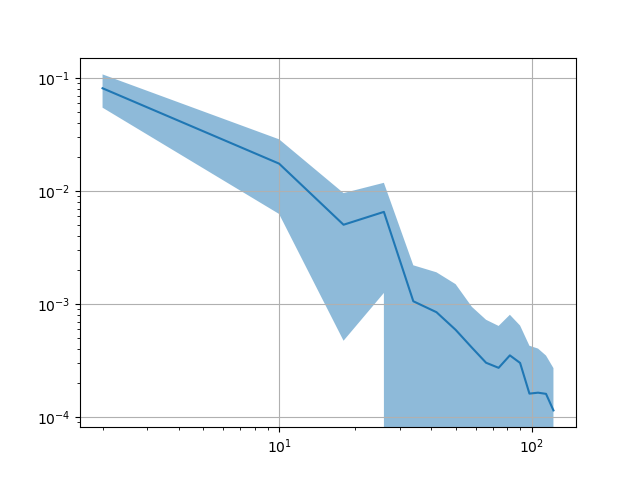

In [19]:
plt.figure()
plt.plot(ms, SE_means)
plt.fill_between(ms, SE_means+SE_stds, SE_means-SE_stds, alpha=.5)
plt.xscale('log'), plt.yscale('log')
plt.grid(), plt.show();